In [1]:
import tensorflow as tf
from tensorflow.contrib import slim
import numpy as np
import time

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from scipy.io import loadmat

from skimage.color import rgb2hed, rgb2hsv, hsv2rgb
# implements colour deconv using the standard stained matrix fromb

`rgb2hsv` = A. C. Ruifrok and D. A. Johnston “Quantification of histochemical staining by color deconvolution.,” Analytical and quantitative cytology and histology / the International Academy of Cytology [and] American Society of Cytology, vol. 23, no. 4, pp. 291-9, Aug. 2001.

Dataset source:
K. Sirinukunwattana, S.E.A. Raza, Y.W Tsang, I.A. Cree, D.R.J. Snead, N.M. Rajpoot, ‘Locality Sensitive Deep Learning for Detection and Classification of Nuclei in Routine Colon Cancer Histology Images,’ IEEE Transactions on Medical Imaging, 2016 (in press) 

In [2]:
def load_img_data(index):
    imgf = 'Dataset/Detection/img{0}/img{0}.bmp'.format(index)
    detf = 'Dataset/Detection/img{0}/img{0}_detection.mat'.format(index)
    img = mpimg.imread(imgf)
    det = loadmat(detf)['detection']
    return img, det

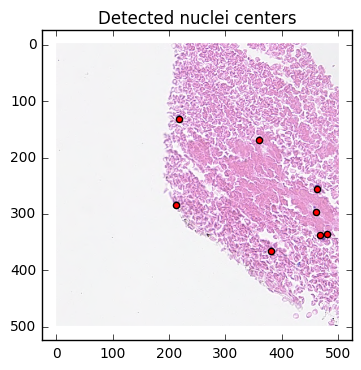

In [3]:
MY_TEST_IMG = 74
img, dets = load_img_data(MY_TEST_IMG)
plt.imshow(img)
plt.scatter(dets[:, 0], dets[:, 1], c='r')
plt.title("Detected nuclei centers")

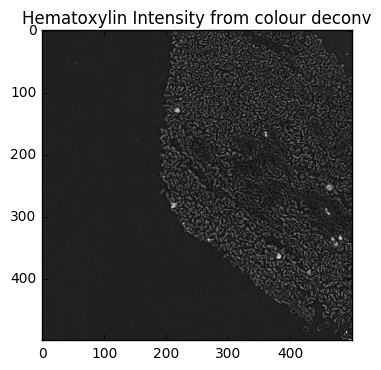

In [4]:
img_hed = rgb2hed(img)
plt.imshow(img_hed[:, :, 0], cmap=plt.cm.gray)
plt.title("Hematoxylin Intensity from colour deconv")

### make patches

In [5]:
def my_augmentation(img):
    augs = ['rot', 'flip', 'rhsv']
    np.random.shuffle(augs)
    for aug in augs:
        if aug == 'rot':
            r = np.random.choice([0, 1, 2, 3])
            img = np.rot90(img, r)
        elif aug == 'flip':
            a = np.random.choice([-1, 0, 1])
            if a == 0:
                img = np.flipud(img)
            elif a == 1:
                img = np.fliplr(img)
        elif aug == 'rhsv':
            # PARAMETERS
            rh = np.random.uniform(0.95, 1.051)
            rs, rv = np.random.uniform(0.9, 1.11, 2)
            img = rgb2hsv(img)
            img *= np.array([rh, rs, rv])
            img = hsv2rgb(img)
        else:
            raise ValueError("Don't know this aug:  " + aug)
    return img
                


# Takes an image and returns NUM_DECTECTIONS+NUM_NEG_PER_IMG
# patches of given size (PATCH_SIZE) with labels
# as a list of (patch, label) tuples
def make_detection_patch_examples(img_id, 
                                  augment=False, 
                                  deconv=False, 
                                  shuffle=False, 
                                  height=27, 
                                  width=27, 
                                  num_neg=1,
                                  cell_rad=0):
    img, detections = load_img_data(img_id);
    detections = np.ceil(detections).astype(np.uint16) - 1
    dy = height/2
    dx = width/2
        
    # create a padded matrix of zeros to set to one for detected nuclei with radius cell_rad
    det = np.zeros((img.shape[0]+2*cell_rad, img.shape[1]+2*cell_rad), dtype=np.bool)
    for x, y in detections:
        det[x-cell_rad:x+cell_rad+1, y-cell_rad:y+cell_rad+1] = 1
    
    det = det[cell_rad:-(cell_rad+1), cell_rad:-(cell_rad+1)] # crop out the padding
    
    num_pos = np.count_nonzero(det)
    pos_det = np.array(np.nonzero(det)).T        
    neg_det = np.array(np.nonzero(~det)).T
    
    if num_neg <= 1: # if leq 1, use as ratio with num_pos
        num_neg = int(num_pos * num_neg) # balance pos-neg examples
    
    # deterministically sample negatives
    np.random.seed(img_id)
    neg_samples = np.random.permutation(neg_det.shape[0])[:num_neg]
    np.random.seed(int(time.time()))
    
    neg_det = neg_det[neg_samples, ]
    
    img = np.pad(img, ((dy+1,), (dx+1,), (0,)), 'symmetric')
            
    patches = []
    centers = np.vstack((pos_det, neg_det))

    labels = [1] * num_pos + [0] * num_neg
    labels = np.vstack(labels)
    # pos eg
    for x,y in centers:
        x += dy+1
        y += dx+1
        patch = img[y-dy:y+dy+1, x-dx:x+dx+1, :]
        if augment:
            patch = my_augmentation(patch)            
        if deconv:
            patch = rgb2hed(patch)[:, :, 0]
        patches.append(patch)

    patches = np.stack(patches)
    if shuffle:
        rand_ord = np.random.permutation(num_pos +  num_neg)
        patches = patches[rand_ord,]
        labels = labels[rand_ord,]
        centers = centers[rand_ord,]

    return patches.astype(np.uint8), labels.astype(np.uint8), centers.astype(np.uint16)

(16, 27, 27)


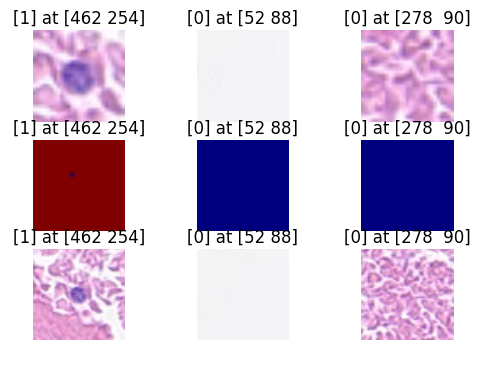

In [6]:
def test_patch_examples(img_id = MY_TEST_IMG, my_num_to_see = 3):
    p, l, c = make_detection_patch_examples(
        img_id, augment=False, deconv=False, shuffle=False)
    p2, l2, c2 = make_detection_patch_examples(
        img_id, augment=False, deconv=True, shuffle=False)
    r = np.random.permutation(p.shape[0])[:my_num_to_see]
    img, det = load_img_data(img_id)
    print p2.shape
    
    for i in range(my_num_to_see):
        plt.subplot(int('{:}{:}{:}'.format(3,my_num_to_see,i+1)))
        plt.imshow(p[r[i],:,:])
        plt.title('{:} at {:}'.format(l[r[i]], c[r[i]]))
        plt.axis('off')
        plt.subplot(
            int('{:}{:}{:}'.format(3,my_num_to_see,i+1+my_num_to_see)))
        plt.imshow(p2[r[i],:,:])
        plt.title('{:} at {:}'.format(l2[r[i]], c2[r[i]]))
        plt.axis('off')
        plt.subplot(
            int('{:}{:}{:}'.format(3,my_num_to_see,i+1+2*my_num_to_see)))
        x, y = c2[r[i]]
        dx, dy = 27, 27
        patch = img[y-dy:y+dy+1, x-dx:x+dx+1, :]
        plt.imshow(patch)
        plt.title('{:} at {:}'.format(l2[r[i]], c2[r[i]]))
        plt.axis('off')

test_patch_examples();

### Load labelled image patches split into training and validation

In [7]:
def load_data(img_ids, 
              augment, 
              deconv, 
              shuffle, 
              height, 
              width, 
              num_neg_per_img,
              cell_radius):
    patches, labels, centers = [], [], []
    for img_id in img_ids:
        p, l, c = make_detection_patch_examples(
            img_id, 
            augment=augment, 
            deconv=deconv, 
            shuffle=shuffle,
            height=height,
            width=width,
            num_neg=num_neg_per_img,
            cell_rad=cell_radius)
        patches.append(p)
        labels.append(l)
        c = np.hstack((c, np.ones((c.shape[0], 1)) * img_id))
        centers.append(c)
        print "Loaded img", img_id
    patches = np.concatenate(patches)
    labels = np.concatenate(labels)
    centers = np.concatenate(centers)
    if shuffle:
        rand_ord = np.random.permutation(patches.shape[0])
        patches = patches[rand_ord,]
        labels = labels[rand_ord,]
        centers = centers[rand_ord,]

    data = {
        'patches': patches,
        'labels': labels,
        'centers': centers,
    }
    return data

#### Constants and Params

In [8]:
NUM_IMGS = 100
VALID_PERC = 0.2
CELL_RADIUS = 0 # In pixels
SHUFFLE = True
AUGMENT = True
PATCH_SIZE_H = 27
PATCH_SIZE_W = 27
NUM_NEG_PER_IMG = 1 # 1 => num detected in img
DECONV = True
POS_THRESHOLD = 0.4
BATCH_SIZE = 300
EPOCHS = 10

#### Load everything

In [9]:
try:
    del t_data, v_data
except:
    pass
t_num_imgs = int(NUM_IMGS * (1-VALID_PERC))
print "Loading training data"
t_data = load_data(img_ids=range(1, t_num_imgs+1),
    augment=AUGMENT, 
    deconv=DECONV, 
    shuffle=SHUFFLE,
    height=PATCH_SIZE_H,
    width=PATCH_SIZE_W,
    num_neg_per_img=NUM_NEG_PER_IMG, cell_radius=0)
print "Loading validation data"
v_data = load_data(img_ids=range(t_num_imgs+1, NUM_IMGS+1),
    augment=False, 
    deconv=DECONV, 
    shuffle=False,
    height=PATCH_SIZE_H,
    width=PATCH_SIZE_W,
    num_neg_per_img=NUM_NEG_PER_IMG, cell_radius=0)

Loading training data
Loaded img 1
Loaded img 2
Loaded img 3
Loaded img 4
Loaded img 5
Loaded img 6
Loaded img 7
Loaded img 8
Loaded img 9
Loaded img 10
Loaded img 11
Loaded img 12
Loaded img 13
Loaded img 14
Loaded img 15
Loaded img 16
Loaded img 17
Loaded img 18
Loaded img 19
Loaded img 20
Loaded img 21
Loaded img 22
Loaded img 23
Loaded img 24
Loaded img 25
Loaded img 26
Loaded img 27
Loaded img 28
Loaded img 29
Loaded img 30
Loaded img 31
Loaded img 32
Loaded img 33
Loaded img 34
Loaded img 35
Loaded img 36
Loaded img 37
Loaded img 38
Loaded img 39
Loaded img 40
Loaded img 41
Loaded img 42
Loaded img 43
Loaded img 44
Loaded img 45
Loaded img 46
Loaded img 47
Loaded img 48
Loaded img 49
Loaded img 50
Loaded img 51
Loaded img 52
Loaded img 53
Loaded img 54
Loaded img 55
Loaded img 56
Loaded img 57
Loaded img 58
Loaded img 59
Loaded img 60
Loaded img 61
Loaded img 62
Loaded img 63
Loaded img 64
Loaded img 65
Loaded img 66
Loaded img 67
Loaded img 68
Loaded img 69
Loaded img 70
Loaded 

In [10]:
for k,v in t_data.items():
    print "train", k, v.shape
for k,v in v_data.items():
    print "valid", k, v.shape    

train labels (47384, 1)
train patches (47384, 27, 27)
train centers (47384, 3)
valid labels (12044, 1)
valid patches (12044, 27, 27)
valid centers (12044, 3)


### define CP-CNN model 

In [11]:
def detection_model_cpcnn(image_batch):
    # Credit to Sandro for "slim" code:
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        # PARAMETERS
                        weights_initializer=
                            tf.truncated_normal_initializer(stddev=0.01),
                        biases_initializer=tf.zeros_initializer,
                        weights_regularizer=slim.l2_regularizer(5e-4),
                        biases_regularizer=None):
        with slim.arg_scope([slim.conv2d, slim.max_pool2d], padding='VALID'):
            with slim.arg_scope([slim.dropout], keep_prob=0.8):
                net = image_batch
                net = slim.conv2d(net, 36, [4, 4], scope='1_conv')
                net = slim.max_pool2d(net, [2, 2], scope='2_max_pool')
                net = slim.conv2d(net, 48, [3, 3], scope='3_conv')
                net = slim.max_pool2d(net, [2, 2], scope='4_max_pool')
                net = slim.flatten(net, scope='4_flatten')
                net = slim.fully_connected(net, 512, scope='5_fc')
                net = slim.dropout(net, scope='5_dropout')
                net = slim.fully_connected(net, 512, scope='6_fc')
                net = slim.dropout(net, scope='6_dropout')
                # linear layer
                net = slim.fully_connected(net, 1, activation_fn=None, scope='7_linear')
                return net

### build tf graph

In [12]:
def get_training_op(predictions, labels):
    loss = slim.losses.mean_squared_error(predictions, labels)
    total_loss = slim.losses.get_total_loss()
    # not decaying learning rate since it's weirdly staircased
    # PARAMETERS
    optimizer = tf.train.MomentumOptimizer(momentum=0.9, learning_rate=1e-2)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    return (train_op, loss)

In [13]:
def train_loop(sess, patch_tensor, label_tensor, 
               train_patches, train_labels,
               test_patches, test_labels,
               train_op, rms_loss, epochs, batch_size, 
               predictions, train_stats, test_stats, reset=True):
    tr_loss = []
    tst_loss = []
    tr_stats = []
    tst_stats = []
    N = train_patches.shape[0]
    assert train_labels.shape[0] == N
    if reset:
        sess.run(tf.global_variables_initializer())
    for e in xrange(epochs):
        for i in xrange(0, N, batch_size):
            [_, loss, p] = sess.run([train_op, rms_loss, predictions], feed_dict={
                    patch_tensor:np.expand_dims(train_patches[i:i+batch_size], -1),
                    label_tensor:train_labels[i:i+batch_size],
                })            
            step = i / batch_size            
            if step % 10 == 0:
                [tst_loss_val, tr_vals, tst_vals] = sess.run([rms_loss, train_stats, test_stats], feed_dict={
                    patch_tensor:np.expand_dims(test_patches, -1),
                    label_tensor:test_labels,
                })
                tr_loss.append(loss)
                tst_loss.append(tst_loss_val)
        [tst_loss_val, tr_vals, tst_vals] = sess.run([rms_loss, train_stats, test_stats], feed_dict={
            patch_tensor:np.expand_dims(test_patches, -1),
            label_tensor:test_labels,
        })
        tr_loss.append(loss)
        tst_loss.append(tst_loss_val)
        tr_stats.append(tr_vals)
        tst_stats.append(tst_vals)
        print "EOF Epoch %d, training loss %f, test_loss %f, train/val accuracy = %s/%s" \
            % (e+1, loss, tst_loss_val, tr_vals, tst_vals)
    return (tr_loss, tst_loss, tr_stats, tst_stats)


In [14]:
def get_accuracy(predictions, labels, thres):
    labs = tf.cast(labels, tf.bool)
    predpos = tf.greater_equal(predictions, thres)
    numpredpos = tf.reduce_sum(tf.cast(predpos, tf.int32))
    trupos = tf.reduce_sum(tf.cast(tf.logical_and(predpos, labs), tf.int32))    
    precision = tf.truediv(trupos, numpredpos)
    recall = tf.truediv(trupos, tf.reduce_sum(labels))
    f1 = 2 * tf.truediv(tf.mul(precision, recall), tf.add(precision, recall))
    return precision, recall, f1

In [15]:
try:
    sess.close()
except:
    pass

detection_model = detection_model_cpcnn

tf.reset_default_graph()
sess = tf.InteractiveSession()
patch_tensor = tf.placeholder(dtype='float32',
                              shape=(None, PATCH_SIZE_H, PATCH_SIZE_W, 1))
label_tensor = tf.placeholder(dtype='int32', shape=(None, 1))

# Use dropout for training to avoid overfitting
with tf.variable_scope("detector"):
    with slim.arg_scope([slim.dropout], is_training=True):
        prediction_probs = detection_model(patch_tensor)
# Turn off dropout for testing
with tf.variable_scope("detector", reuse=True):
    with slim.arg_scope([slim.dropout], is_training=False):
        inference_prediction_probs = detection_model(patch_tensor)        

(train_op, loss) = get_training_op(prediction_probs, label_tensor)        
predictions = prediction_probs
inference_predictions = inference_prediction_probs

In [16]:
train_stats = get_accuracy(predictions, label_tensor, POS_THRESHOLD)
test_stats = get_accuracy(inference_predictions, label_tensor, POS_THRESHOLD)
tr_loss, tst_loss, tr_stats, tst_stats = train_loop(sess, patch_tensor, label_tensor, 
                               t_data['patches'], t_data['labels'], v_data['patches'], 
                               v_data['labels'], train_op, loss, 
                               EPOCHS, BATCH_SIZE,
                               predictions, train_stats, test_stats)

EOF Epoch 1, training loss 0.213381, test_loss 0.195774, train/val accuracy = (0.5644420131291028, 0.85669212886084356, 0.68051708217913198)/(0.55700775688024651, 0.87047492527399539, 0.67932352750599367)
EOF Epoch 2, training loss 0.205597, test_loss 0.193256, train/val accuracy = (0.56713800284993976, 0.85918299568249756, 0.68326180257510738)/(0.55982495463763471, 0.87097309863832617, 0.68156714963290232)
EOF Epoch 3, training loss 0.206667, test_loss 0.188203, train/val accuracy = (0.6378845881185311, 0.74709398870807042, 0.68818355640535378)/(0.58691522203752078, 0.82082364662902685, 0.68443644419828298)
EOF Epoch 4, training loss 0.203525, test_loss 0.187492, train/val accuracy = (0.58813035204567077, 0.82115576220524744, 0.6853776853776854)/(0.58203440711234267, 0.83709730986383257, 0.68664441871552129)
EOF Epoch 5, training loss 0.201797, test_loss 0.185971, train/val accuracy = (0.76733373761875889, 0.63035536366655598, 0.69213237305132647)/(0.7777317022600041, 0.62288276320159

In [17]:
saver = tf.train.Saver()
print saver.save(sess, "detection_models/cp_cnn_model.ckpt")

detection_models/cp_cnn_model.ckpt


In [ ]:
plt.figure()
plt.plot(range(len(tr_stats)), [n[0] for n in tr_stats], 'b', label='Precision')
plt.plot(range(len(tr_stats)), [n[1] for n in tr_stats], 'g', label='Recall')
plt.plot(range(len(tr_stats)), [n[2] for n in tr_stats], 'r', label='F1')
plt.legend(framealpha=0, loc=1)
plt.xlabel("Epochs")
plt.ylabel("Training Set Statistics")
plt.title("Statistics")

In [ ]:
plt.figure()
plt.plot(range(len(tst_stats)), [n[0] for n in tst_stats], 'b', label='Precision')
plt.plot(range(len(tst_stats)), [n[1] for n in tst_stats], 'g', label='Recall')
plt.plot(range(len(tst_stats)), [n[2] for n in tst_stats], 'r', label='F1')
plt.legend(framealpha=0, loc=1)
plt.xlabel("Epochs")
plt.ylabel("Test Set Statistics")
plt.title("Statistics")

In [ ]:
plt.figure()
plt.plot(range(len(tr_loss)), tr_loss, 'b', label='Train')
plt.plot(range(len(tst_loss)), tst_loss, 'g', label='Test')
plt.legend(framealpha=0)
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (loss)")
plt.title("Loss during training")